<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
response

<Response [200]>

In [4]:
# json文字列をdictへ
j_res = json.loads(response.text)
j_res.keys()

dict_keys(['contacts', 'querents', 'patients', 'patients_summary', 'discharges_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])

In [5]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [6]:
keys = ['contacts', 'querents', 'patients_summary', 'discharges_summary']

In [7]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,discharges_count,datetime
2020-01-24 17:00:00+09:00,0,0,2,0,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,0,0,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...,...
2020-10-15 17:00:00+09:00,354,1158,284,0,2020-10-15 17:00:00+09:00
2020-10-16 17:00:00+09:00,347,1142,184,0,2020-10-16 17:00:00+09:00
2020-10-17 17:00:00+09:00,318,772,235,0,2020-10-17 17:00:00+09:00
2020-10-18 17:00:00+09:00,347,760,132,0,2020-10-18 17:00:00+09:00


In [8]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,discharges_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,discharges_7d_mov_ave,discharges_7d_mov_sum
2020-10-15 17:00:00+09:00,354,1158,284,0,2020-10-15 17:00:00+09:00,423.285714,2963.0,1262.857143,8840.0,186.000000,1302.0,0.0,0.0
2020-10-16 17:00:00+09:00,347,1142,184,0,2020-10-16 17:00:00+09:00,417.142857,2920.0,1239.285714,8675.0,183.285714,1283.0,0.0,0.0
2020-10-17 17:00:00+09:00,318,772,235,0,2020-10-17 17:00:00+09:00,398.428571,2789.0,1213.714286,8496.0,181.428571,1270.0,0.0,0.0
2020-10-18 17:00:00+09:00,347,760,132,0,2020-10-18 17:00:00+09:00,383.000000,2681.0,1184.571429,8292.0,179.428571,1256.0,0.0,0.0
2020-10-19 17:00:00+09:00,0,0,78,0,2020-10-19 17:00:00+09:00,307.714286,2154.0,897.000000,6279.0,179.428571,1256.0,0.0,0.0


In [9]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,discharges_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,discharges_7d_mov_ave,discharges_7d_mov_sum,week_num,week_day
2020-10-05 17:00:00+09:00,576,1930,66,0,2020-10-05 17:00:00+09:00,469.142857,3284.0,1353.428571,9474.0,173.857143,1217.0,0.0,0.0,'20w41,Mon
2020-10-06 17:00:00+09:00,460,1385,177,0,2020-10-06 17:00:00+09:00,469.428571,3286.0,1348.428571,9439.0,168.857143,1182.0,0.0,0.0,'20w41,Tue
2020-10-07 17:00:00+09:00,475,1403,141,0,2020-10-07 17:00:00+09:00,476.000000,3332.0,1358.428571,9509.0,161.285714,1129.0,0.0,0.0,'20w41,Wed
2020-10-08 17:00:00+09:00,412,1306,248,0,2020-10-08 17:00:00+09:00,472.857143,3310.0,1360.142857,9521.0,163.142857,1142.0,0.0,0.0,'20w41,Thu
2020-10-09 17:00:00+09:00,390,1307,203,0,2020-10-09 17:00:00+09:00,472.714286,3309.0,1354.000000,9478.0,164.142857,1149.0,0.0,0.0,'20w41,Fri
2020-10-10 17:00:00+09:00,449,951,248,0,2020-10-10 17:00:00+09:00,464.571429,3252.0,1340.714286,9385.0,170.142857,1191.0,0.0,0.0,'20w41,Sat
2020-10-11 17:00:00+09:00,455,964,146,0,2020-10-11 17:00:00+09:00,459.571429,3217.0,1320.857143,9246.0,175.571429,1229.0,0.0,0.0,'20w41,Sun
2020-10-12 17:00:00+09:00,527,2013,78,0,2020-10-12 17:00:00+09:00,452.571429,3168.0,1332.714286,9329.0,177.285714,1241.0,0.0,0.0,'20w42,Mon
2020-10-13 17:00:00+09:00,397,1271,166,0,2020-10-13 17:00:00+09:00,443.571429,3105.0,1316.428571,9215.0,175.714286,1230.0,0.0,0.0,'20w42,Tue
2020-10-14 17:00:00+09:00,391,1176,177,0,2020-10-14 17:00:00+09:00,431.571429,3021.0,1284.000000,8988.0,180.857143,1266.0,0.0,0.0,'20w42,Wed


In [10]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [11]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2020-09-27 17:00:00+09:00,149.428571,1046
2020-10-04 17:00:00+09:00,175.571429,1229
2020-10-11 17:00:00+09:00,175.571429,1229
2020-10-18 17:00:00+09:00,179.428571,1256
2020-10-19 17:00:00+09:00,78.000000,78


In [12]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,discharges_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,discharges_7d_mov_ave,discharges_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2020-10-05 17:00:00+09:00,576,1930,66,0,2020-10-05 17:00:00+09:00,469.142857,3284.0,1353.428571,9474.0,173.857143,1217.0,0.0,0.0,'20w41,Mon,NaN,NaN
2020-10-06 17:00:00+09:00,460,1385,177,0,2020-10-06 17:00:00+09:00,469.428571,3286.0,1348.428571,9439.0,168.857143,1182.0,0.0,0.0,'20w41,Tue,NaN,NaN
2020-10-07 17:00:00+09:00,475,1403,141,0,2020-10-07 17:00:00+09:00,476.000000,3332.0,1358.428571,9509.0,161.285714,1129.0,0.0,0.0,'20w41,Wed,NaN,NaN
2020-10-08 17:00:00+09:00,412,1306,248,0,2020-10-08 17:00:00+09:00,472.857143,3310.0,1360.142857,9521.0,163.142857,1142.0,0.0,0.0,'20w41,Thu,NaN,NaN
2020-10-09 17:00:00+09:00,390,1307,203,0,2020-10-09 17:00:00+09:00,472.714286,3309.0,1354.000000,9478.0,164.142857,1149.0,0.0,0.0,'20w41,Fri,NaN,NaN
2020-10-10 17:00:00+09:00,449,951,248,0,2020-10-10 17:00:00+09:00,464.571429,3252.0,1340.714286,9385.0,170.142857,1191.0,0.0,0.0,'20w41,Sat,NaN,NaN
2020-10-11 17:00:00+09:00,455,964,146,0,2020-10-11 17:00:00+09:00,459.571429,3217.0,1320.857143,9246.0,175.571429,1229.0,0.0,0.0,'20w41,Sun,175.571429,1229.0
2020-10-12 17:00:00+09:00,527,2013,78,0,2020-10-12 17:00:00+09:00,452.571429,3168.0,1332.714286,9329.0,177.285714,1241.0,0.0,0.0,'20w42,Mon,NaN,NaN
2020-10-13 17:00:00+09:00,397,1271,166,0,2020-10-13 17:00:00+09:00,443.571429,3105.0,1316.428571,9215.0,175.714286,1230.0,0.0,0.0,'20w42,Tue,NaN,NaN
2020-10-14 17:00:00+09:00,391,1176,177,0,2020-10-14 17:00:00+09:00,431.571429,3021.0,1284.000000,8988.0,180.857143,1266.0,0.0,0.0,'20w42,Wed,NaN,NaN


### グラフ出力

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
y2_1 = df3['patients_7d_mov_sum']
y2_2 = df3['patients_week_sum']

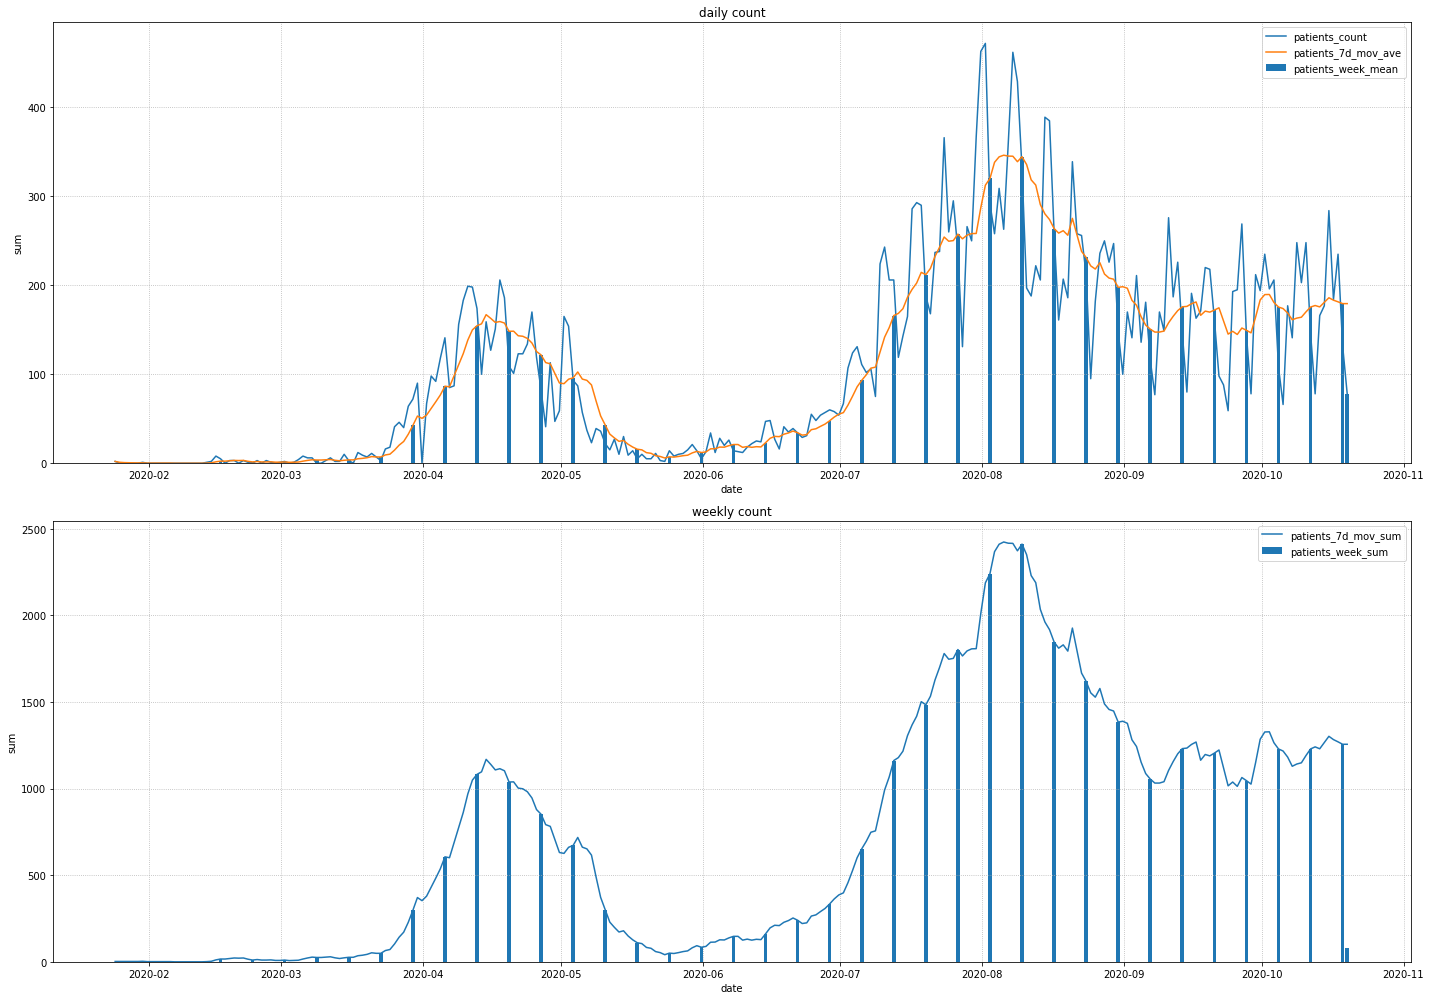

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
ax[0].bar(x, y1_4, label='patients_week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の合計
ax[1].set_title('weekly count')
ax[1].set_xlabel('date')
ax[1].set_ylabel('sum')
ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
ax[1].bar(x, y2_2, label='patients_week_sum')
ax[1].grid(linestyle=':')
ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count,discharges_7d_mov_ave,discharges_7d_mov_sum
255,1.601885e+09,2020,10,5,0,1,0,0,0,0,0,255,0,181,576,469.142857,3284.0,1930,1353.428571,9474.0,66,173.857143,1217.0,0,0.0,0.0
256,1.601971e+09,2020,10,6,0,0,0,0,0,1,0,256,0,182,460,469.428571,3286.0,1385,1348.428571,9439.0,177,168.857143,1182.0,0,0.0,0.0
257,1.602058e+09,2020,10,7,0,0,0,0,0,0,1,257,0,183,475,476.000000,3332.0,1403,1358.428571,9509.0,141,161.285714,1129.0,0,0.0,0.0
258,1.602144e+09,2020,10,8,0,0,0,0,1,0,0,258,0,184,412,472.857143,3310.0,1306,1360.142857,9521.0,248,163.142857,1142.0,0,0.0,0.0
259,1.602230e+09,2020,10,9,1,0,0,0,0,0,0,259,0,185,390,472.714286,3309.0,1307,1354.000000,9478.0,203,164.142857,1149.0,0,0.0,0.0
260,1.602317e+09,2020,10,10,0,0,1,0,0,0,0,260,0,186,449,464.571429,3252.0,951,1340.714286,9385.0,248,170.142857,1191.0,0,0.0,0.0
261,1.602403e+09,2020,10,11,0,0,0,1,0,0,0,261,0,187,455,459.571429,3217.0,964,1320.857143,9246.0,146,175.571429,1229.0,0,0.0,0.0
262,1.602490e+09,2020,10,12,0,1,0,0,0,0,0,262,0,188,527,452.571429,3168.0,2013,1332.714286,9329.0,78,177.285714,1241.0,0,0.0,0.0
263,1.602576e+09,2020,10,13,0,0,0,0,0,1,0,263,0,189,397,443.571429,3105.0,1271,1316.428571,9215.0,166,175.714286,1230.0,0,0.0,0.0
264,1.602662e+09,2020,10,14,0,0,0,0,0,0,1,264,0,190,391,431.571429,3021.0,1176,1284.000000,8988.0,177,180.857143,1266.0,0,0.0,0.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              270 non-null    float64
 1   year                   270 non-null    int64  
 2   month                  270 non-null    int64  
 3   day                    270 non-null    int64  
 4   Fri                    270 non-null    uint8  
 5   Mon                    270 non-null    uint8  
 6   Sat                    270 non-null    uint8  
 7   Sun                    270 non-null    uint8  
 8   Thu                    270 non-null    uint8  
 9   Tue                    270 non-null    uint8  
 10  Wed                    270 non-null    uint8  
 11  passed                 270 non-null    int64  
 12  emergency              270 non-null    int64  
 13  em_passed              270 non-null    int64  
 14  contacts_count         270 non-null    int64  
 15  contac

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count,discharges_7d_mov_ave,discharges_7d_mov_sum
count,2.700000e+02,270.0,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.0,270.0,270.0
mean,1.591474e+09,2020.0,5.700000,15.644444,0.144444,0.144444,0.144444,0.144444,0.140741,0.140741,0.140741,134.500000,0.181481,70.777778,807.318519,804.597266,5632.166667,1318.281481,1310.976720,9176.837037,107.577778,105.809153,740.581481,0.0,0.0,0.0
std,6.746673e+06,0.0,2.585849,8.848974,0.352193,0.352193,0.352193,0.352193,0.348400,0.348400,0.348400,78.086491,0.386132,65.045214,497.268444,483.307584,3383.176708,787.008034,601.996691,4213.976838,107.678509,98.652337,690.654540,0.0,0.0,0.0
min,1.579853e+09,2020.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,1.585663e+09,2020.0,3.250000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.250000,0.000000,0.000000,482.500000,477.214286,3340.500000,792.750000,978.642857,6850.500000,10.000000,9.500000,66.500000,0.0,0.0,0.0
50%,1.591474e+09,2020.0,6.000000,15.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,134.500000,0.000000,60.500000,655.000000,666.214286,4663.500000,1312.500000,1318.642857,9230.500000,78.000000,91.642857,641.500000,0.0,0.0,0.0
75%,1.597284e+09,2020.0,8.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,201.750000,0.000000,127.750000,1029.500000,1028.428571,7199.000000,1810.750000,1750.821429,12255.750000,185.500000,175.571429,1229.000000,0.0,0.0,0.0
max,1.603094e+09,2020.0,10.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,269.000000,1.000000,195.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,472.000000,346.285714,2424.000000,0.0,0.0,0.0


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count,discharges_7d_mov_ave,discharges_7d_mov_sum
timestamp,1.000000,NaN,0.993668,-0.025081,-0.007908,0.007908,-0.002636,0.002636,0.005193,-0.005193,0.000000,1.000000,-0.220508,0.976742,0.090569,0.147683,0.147689,0.444098,0.643703,0.643703,0.658877,0.729246,0.729359,NaN,NaN,NaN
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,0.993668,NaN,1.000000,-0.137085,-0.009388,0.006939,-0.001225,0.002857,0.005777,-0.006602,0.001651,0.993668,-0.217059,0.969499,0.093178,0.148109,0.148116,0.443904,0.645631,0.645631,0.658952,0.727055,0.727180,NaN,NaN,NaN
day,-0.025081,NaN,-0.137085,1.000000,0.014155,0.008191,-0.013280,-0.001352,-0.005413,0.012674,-0.015059,-0.025081,0.002635,-0.022795,-0.007695,0.008469,0.008463,-0.021037,-0.052456,-0.052456,-0.052558,-0.039716,-0.039836,NaN,NaN,NaN
Fri,-0.007908,NaN,-0.009388,0.014155,1.000000,-0.168831,-0.168831,-0.168831,-0.166293,-0.166293,-0.166293,-0.007908,-0.002126,-0.004922,-0.020153,-0.007313,-0.007312,0.064551,-0.008748,-0.008748,0.092876,-0.004171,-0.004305,NaN,NaN,NaN
Mon,0.007908,NaN,0.006939,0.008191,-0.168831,1.000000,-0.168831,-0.168831,-0.166293,-0.166293,-0.166293,0.007908,-0.002126,0.008709,0.041064,-0.005239,-0.005237,0.268613,-0.004911,-0.004911,-0.156109,0.002470,0.002496,NaN,NaN,NaN
Sat,-0.002636,NaN,-0.001225,-0.013280,-0.168831,-0.168831,1.000000,-0.168831,-0.166293,-0.166293,-0.166293,-0.002636,-0.002126,-0.000379,0.035036,-0.006321,-0.006319,-0.327074,-0.006815,-0.006815,0.115912,-0.000686,-0.000713,NaN,NaN,NaN
Sun,0.002636,NaN,0.002857,-0.001352,-0.168831,-0.168831,-0.168831,1.000000,-0.166293,-0.166293,-0.166293,0.002636,-0.002126,0.004165,-0.014485,-0.005239,-0.005237,-0.300827,-0.004911,-0.004911,-0.036224,0.001296,0.001304,NaN,NaN,NaN
Thu,0.005193,NaN,0.005777,-0.005413,-0.166293,-0.166293,-0.166293,-0.166293,1.000000,-0.163793,-0.163793,0.005193,0.002866,0.002041,-0.003071,0.009276,0.009278,0.088700,0.011501,0.011501,0.093548,0.004199,0.004247,NaN,NaN,NaN
Tue,-0.005193,NaN,-0.006602,0.012674,-0.166293,-0.166293,-0.166293,-0.166293,-0.163793,1.000000,-0.163793,-0.005193,0.002866,-0.007145,-0.025644,0.006926,0.006928,0.122255,0.005591,0.005591,-0.049542,-0.002912,-0.002875,NaN,NaN,NaN


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum', 'discharges_count',
       'discharges_7d_mov_ave', 'discharges_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          'discharges_7d_mov_ave', 'discharges_7d_mov_sum'], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,2,2.000000,2.0,0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,0,1.000000,2.0,0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0,0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0,0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,1.602749e+09,0,0,0,0,1,0,0,265,0,191,354,1158,284,186.000000,1302.0,0
266,1.602835e+09,1,0,0,0,0,0,0,266,0,192,347,1142,184,183.285714,1283.0,0
267,1.602922e+09,0,0,1,0,0,0,0,267,0,193,318,772,235,181.428571,1270.0,0
268,1.603008e+09,0,0,0,1,0,0,0,268,0,194,347,760,132,179.428571,1256.0,0


In [26]:
import seaborn as sns

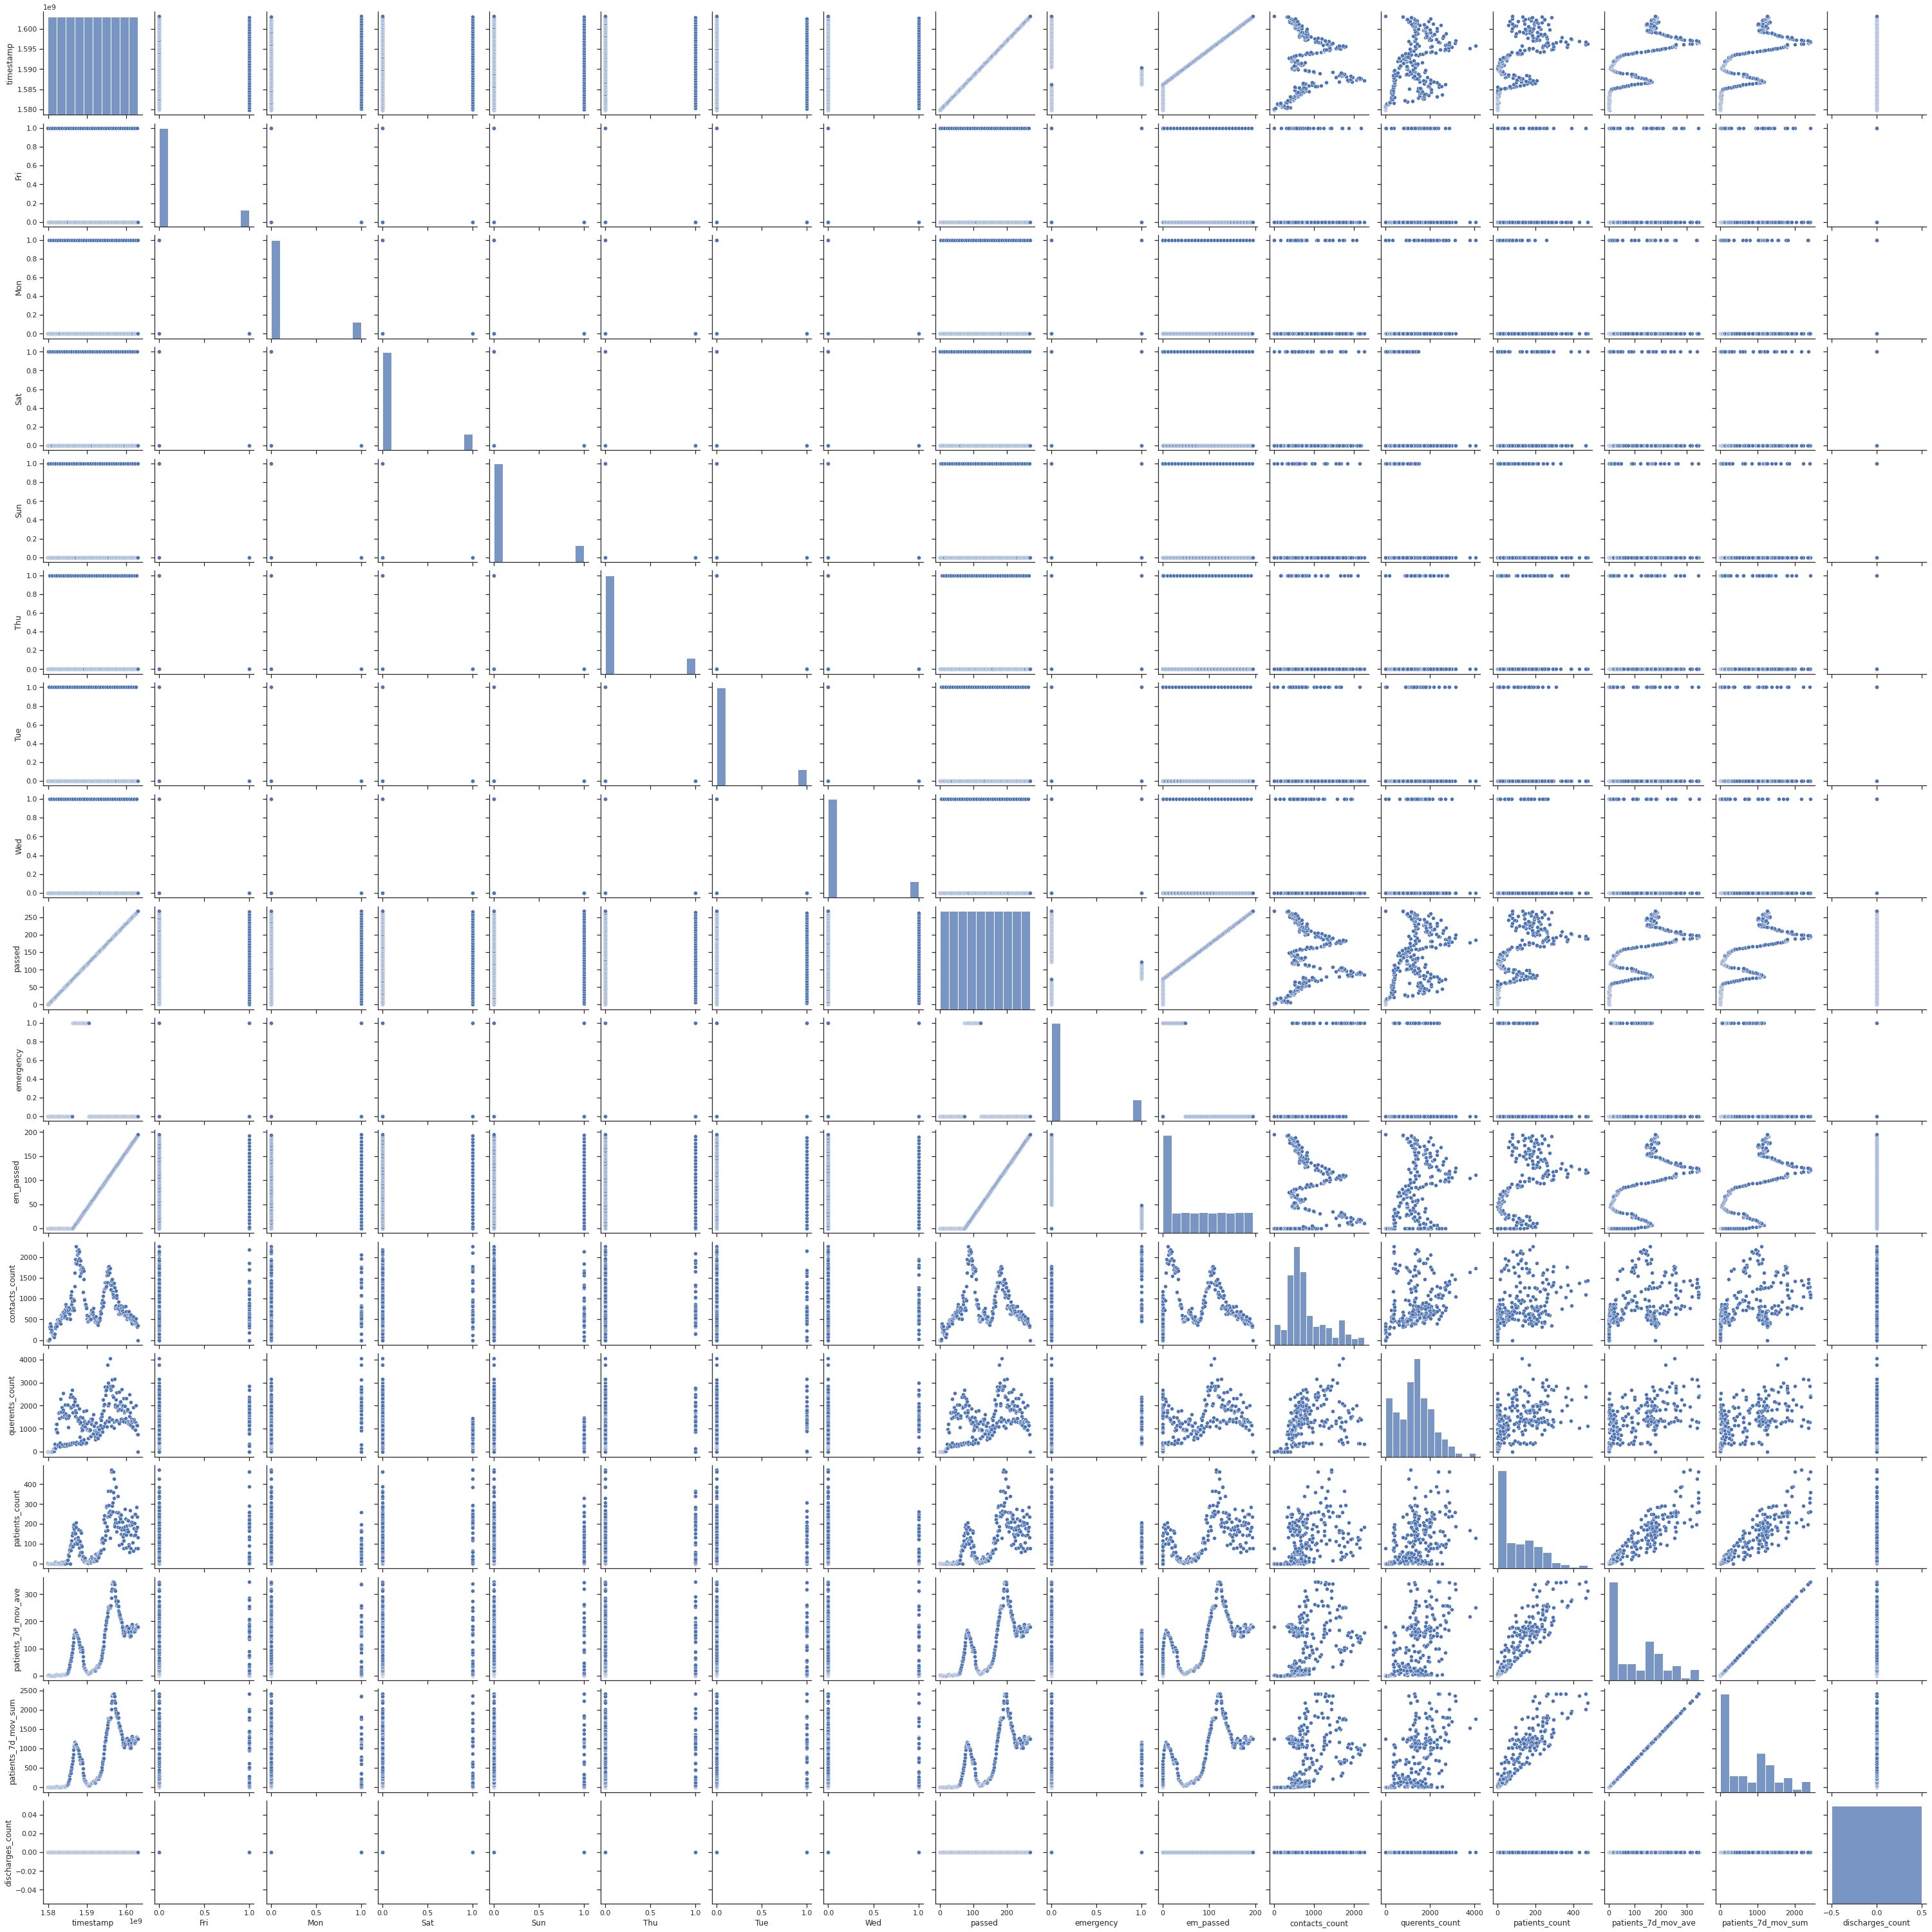

In [27]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=_df);

In [28]:
!python -V

Python 3.6.9
